# Project 1: Adding machine

## Problem
Create a FFN that can add two numbers between -10 and 10.
Input: two numbers between -10 and 10
Output: the sum of the two numbers

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# NEW!
import sklearn.metrics as skm

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Create the data

In [2]:
sample_size = 2000

# generate data
Apy = np.random.randint(-10, 11, sample_size)
Bpy = np.random.randint(-10, 11, sample_size)
labelspy = Apy+Bpy

# put A and B in a single array
datapy = np.array([Apy, Bpy]).T
labelspy = np.array([labelspy]).T
print(datapy.shape)
print(datapy[:5])
print(labelspy[:5])

(2000, 2)
[[  3   1]
 [  3  -8]
 [  1   3]
 [ -4  -8]
 [  6 -10]]
[[  4]
 [ -5]
 [  4]
 [-12]
 [ -4]]


# Organise the data

In [3]:
# Step 1: convert the data to PyTorch tensors
data = torch.tensor(datapy, dtype=torch.float32)
labels = torch.tensor(labelspy, dtype=torch.float32).view(-1, 1) # view is similar to reshape in numpy

print(data.shape)
print(labels.shape)

# Step 2: split the data into training and test sets
data_train, data_devtest, labels_train, labels_devset = train_test_split(data, labels, test_size=0.2)
data_dev, data_test, labels_dev, labels_test = train_test_split(data_devtest, labels_devset, test_size=0.5)

# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(data_train, labels_train)
dev_data = torch.utils.data.TensorDataset(data_dev, labels_dev)
test_data = torch.utils.data.TensorDataset(data_test, labels_test)

# Step 4: create DataLoadersç
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,drop_last=True)
dev_loader = DataLoader(dev_data, batch_size=dev_data.tensors[0].shape[0], shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0], shuffle=True)

torch.Size([2000, 2])
torch.Size([2000, 1])


# Create a function that creates models

In [4]:
def createSumModel():

    class SumModel(nn.Module):
        def __init__(self):
            super().__init__()

            # input layer
            self.input = nn.Linear(2, 32)

            # Hidden layers 
            self.fc1 = nn.Linear(32, 32)
            self.fc2 = nn.Linear(32, 32)

            # output layer
            self.output = nn.Linear(32, 1)
        
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.output(x)
            return x


    net = SumModel()

    lossfun = nn.MSELoss()

    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    return net, lossfun, optimizer

# Create a function that trains the model

In [5]:
def functionTrainModel(model, lossfun, optimizer, train_loader, dev_loader, epochs=10):
    losses = []
    trainAcc = []
    testAcc = []

    
    for epochi in range(epochs):
        batchAcc = []
        batchLoss = []

        model.train()

        for X,y in train_loader:
            # forward pass and loss
            yHat = model(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # accuracy from this batch
            accPct = 100*torch.mean( (np.abs(yHat.detach()-y)<1).float() ) # <1 for rounding
            batchAcc.append(accPct.item())

        # store the average loss and accuracy for this epoch
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        # evaluate on the dev 
        model.eval()
        X,y = next(iter(dev_loader))
        with torch.no_grad():
            yHat = model(X)

        testAcc.append( 100*torch.mean( (np.abs(yHat.detach()-y)<1).float() ).item() )

    return model, losses, trainAcc, testAcc

# Test that everything works

/tmp/ipykernel_786336/4196207563.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  accPct = 100*torch.mean( (np.abs(yHat.detach()-y)<1).float() ) # <1 for rounding
/tmp/ipykernel_786336/4196207563.py:40: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  testAcc.append( 100*torch.mean( (np.abs(yHat.detach()-y)<1).float() ).item() )


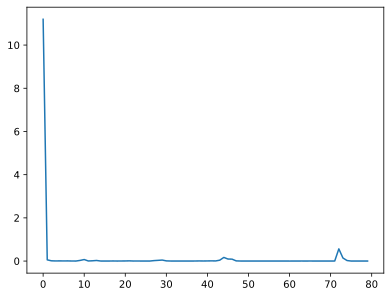

In [6]:
net, lossfun, optimizer = createSumModel()
net, losses, trainAcc, testAcc = functionTrainModel(net, lossfun, optimizer, train_loader, dev_loader, epochs=80)
plt.plot(losses, label='loss')

# Make the experiment
We are going to run the model 10 times to check reproducibility

In [7]:
for i in range(10):
    net, lossfun, optimizer = createSumModel()
    net, losses, trainAcc, testAcc = functionTrainModel(net, lossfun, optimizer, train_loader, dev_loader, epochs=80)
    print(f"Model instance {i+1}: Train Acc {trainAcc[i]:.2f}%, Test Acc {testAcc[i]:.2f}%")

/tmp/ipykernel_786336/4196207563.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  accPct = 100*torch.mean( (np.abs(yHat.detach()-y)<1).float() ) # <1 for rounding
/tmp/ipykernel_786336/4196207563.py:40: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  testAcc.append( 100*torch.mean( (np.abs(yHat.detach()-y)<1).float() ).item() )


Model instance 1: Train Acc 52.31%, Test Acc 89.50%
Model instance 2: Train Acc 100.00%, Test Acc 100.00%
Model instance 3: Train Acc 100.00%, Test Acc 100.00%
Model instance 4: Train Acc 100.00%, Test Acc 100.00%
Model instance 5: Train Acc 100.00%, Test Acc 100.00%
Model instance 6: Train Acc 100.00%, Test Acc 100.00%
Model instance 7: Train Acc 100.00%, Test Acc 100.00%
Model instance 8: Train Acc 100.00%, Test Acc 100.00%
Model instance 9: Train Acc 100.00%, Test Acc 100.00%
Model instance 10: Train Acc 100.00%, Test Acc 100.00%
